In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!pip install pydot
!rm -rf ./logs/ 

# Artificial neural networks (ANN)

Artificial neural networks (ANN) or *connectionist systems* are computing systems vaguely inspired by the biological neural networks that constitute animal brains.

An ANN is based on a collection of connected units or nodes called *artificial neurons*, where each connection can transmit a signal to other neurons.

In ANN implementations, the "signal" at a connection (also known as an edge) is a real number, and the output of each neuron is computed by some non-linear function of the sum of its weighted inputs. The weight increases or decreases the strength of the signal at a connection. Neurons may have a threshold such that a signal is sent only if the aggregate signal crosses that threshold. Typically, neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times.

The original goal of the ANN approach was to solve problems in the same way that a human brain would. But over time, attention moved to performing specific tasks, leading to deviations from biology. ANNs have been used on a variety of tasks, including computer vision, speech recognition, machine translation and even in activities that have traditionally been considered as reserved to humans, like painting.

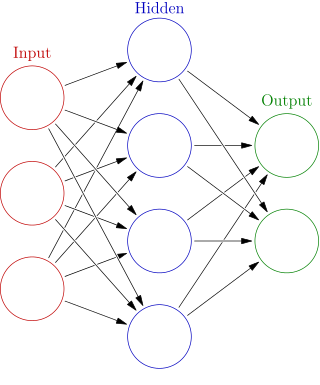

[[1](https://en.wikipedia.org/wiki/File:Colored_neural_network.svg)]

> An artificial neural network is an interconnected group of nodes, inspired by a simplification of neurons in a brain. Here, each circular node represents an artificial neuron and an arrow represents a connection from the output of one artificial neuron to the input of another.

## Artificial neuron

A artificial neuron is a simple model that sums the inputs, where each input is weighted seperately and passed through an *non-linear* function $h$ (also known as an activation function or transfer function). The non-linear activation functions, usually have a sigmoid shape, however can take other forms too. The *non-linear* function allows the ANN to compute nontrivial problems using only a small number of nodes, such as solving the XOR logic problem.


$$ \hat{y} = h\left(w_0 + \sum\limits_{i=1}^m x_i w_i\right)$$
<br>
$$ \hat{y} = h\left(w_0 + \bf{X}^T \bf{W}\right)$$
<br>
<br>
Where: $\bf{X}=\begin{bmatrix}
           x_{1} \\
           x_{2} \\
           \vdots \\
           x_{m}
         \end{bmatrix}$ and $\bf{W}=\begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{m}
         \end{bmatrix}$

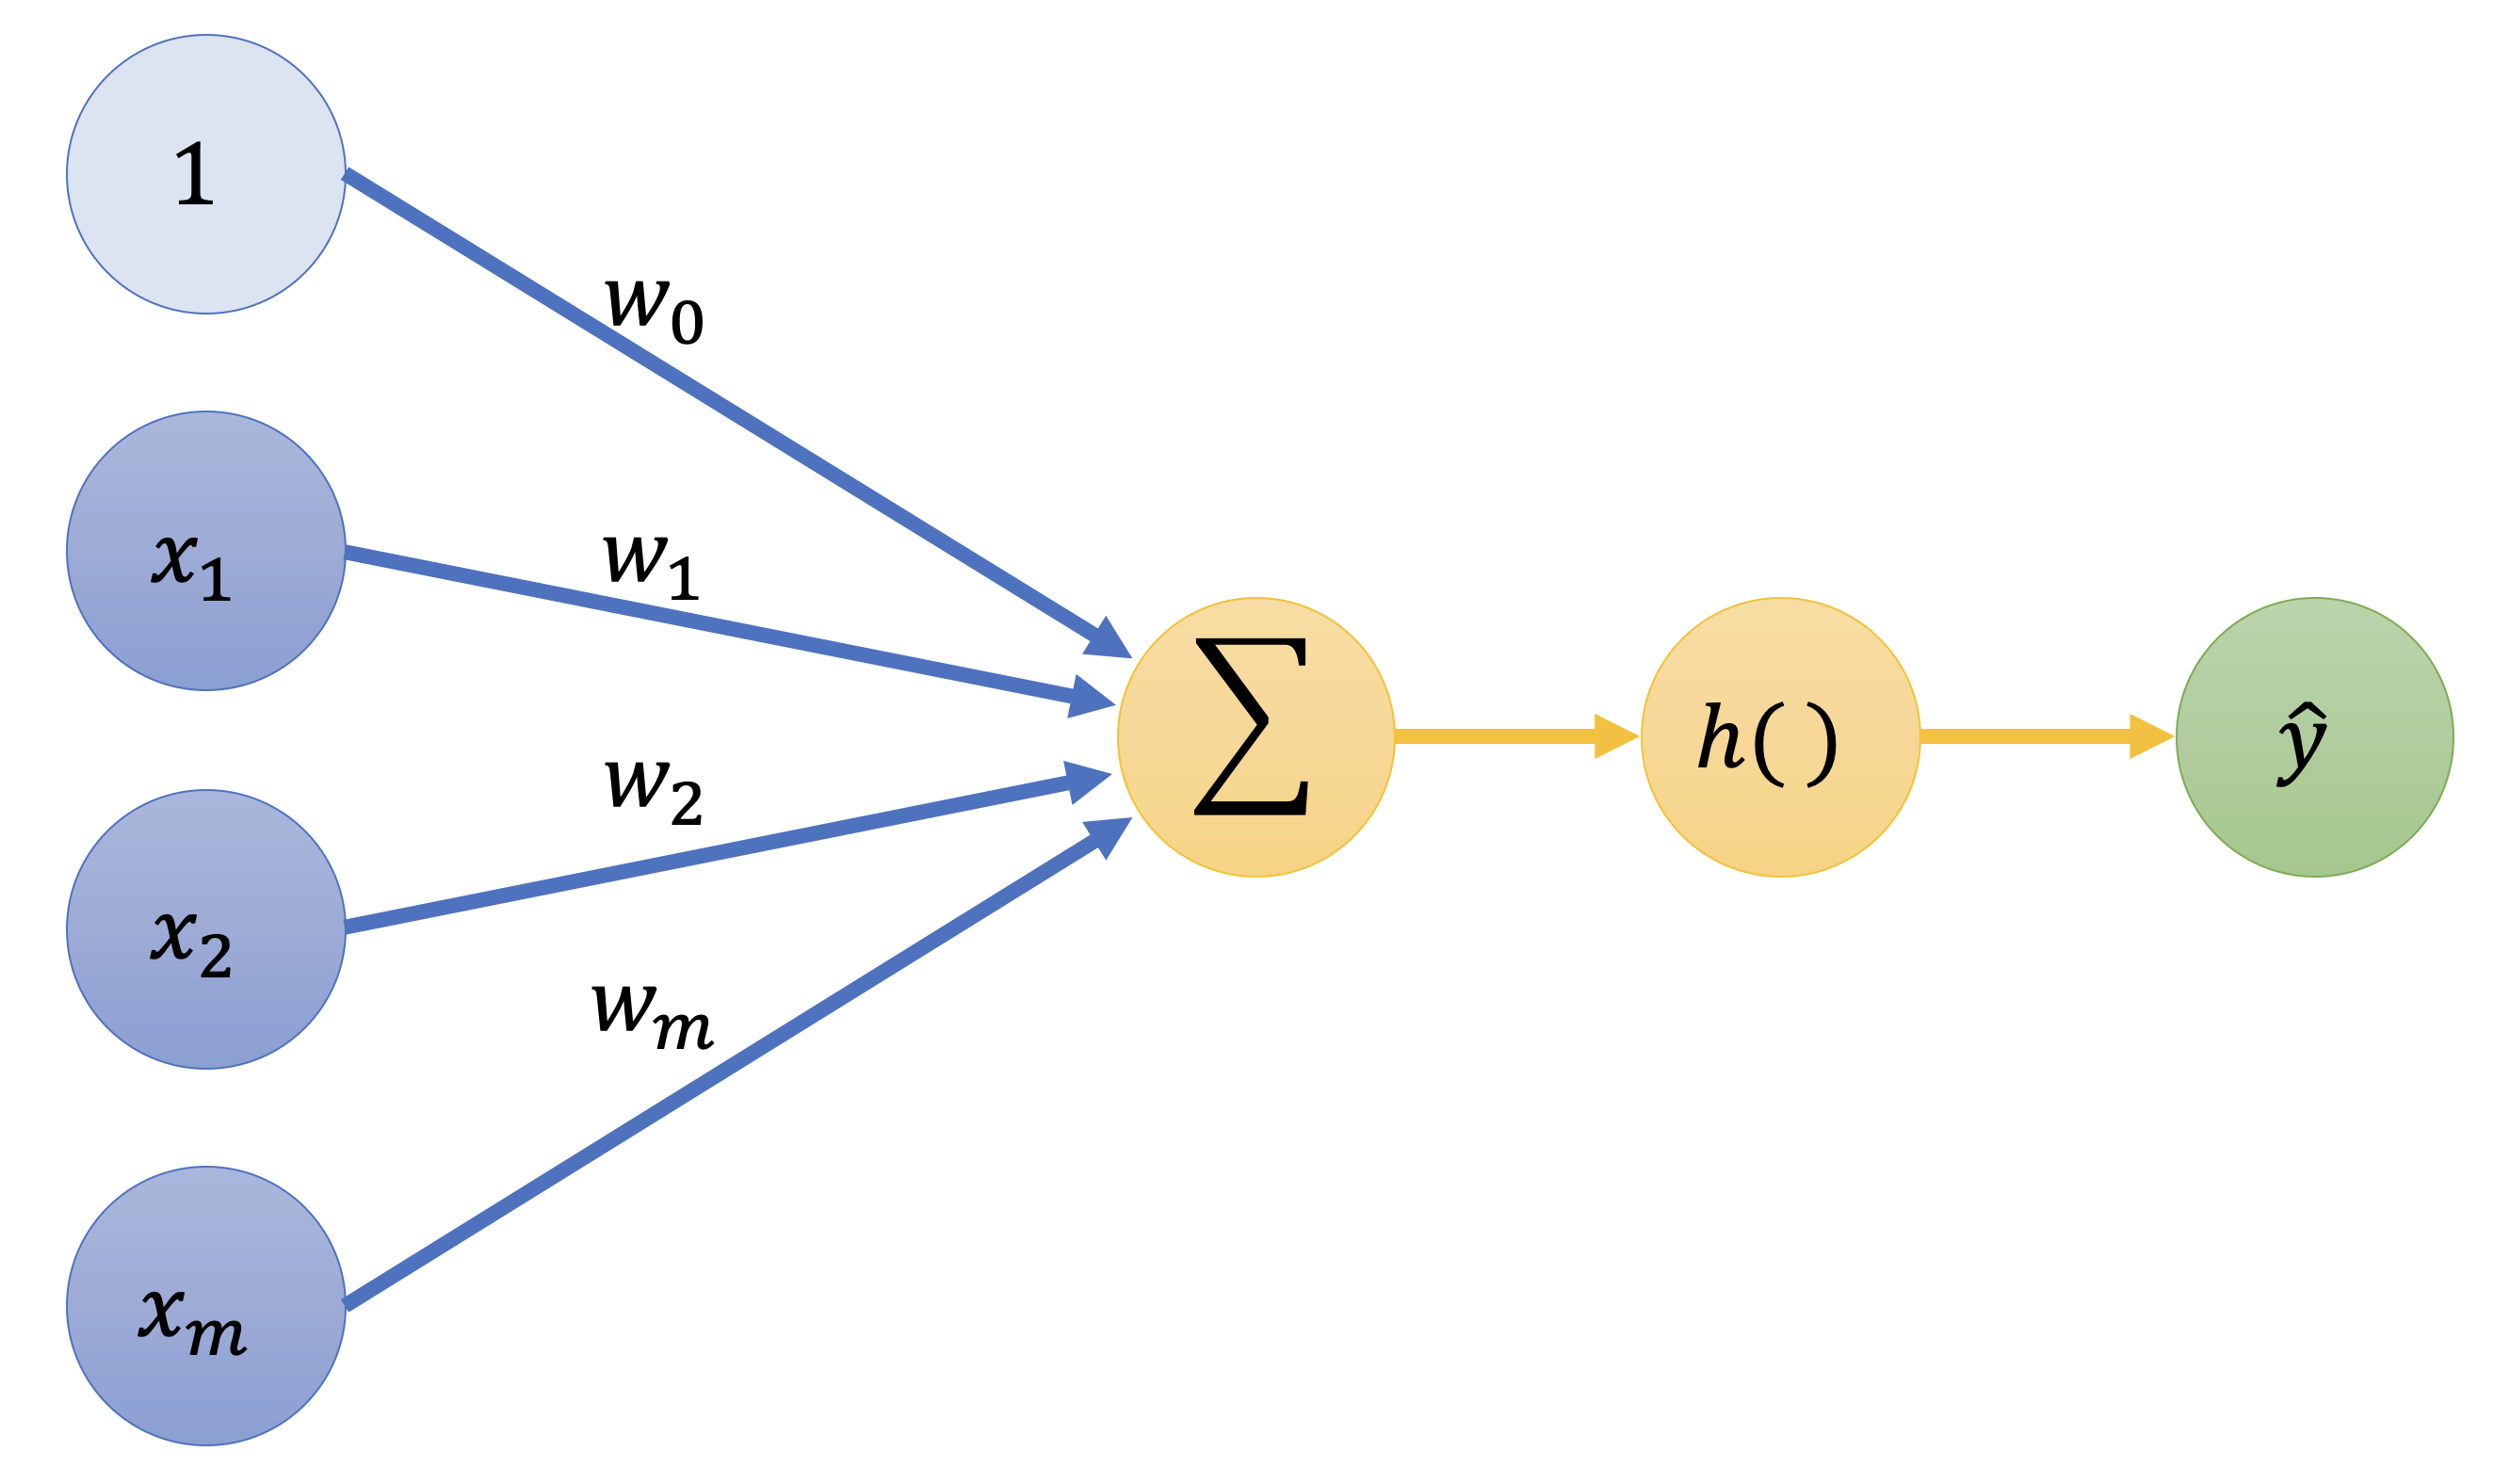


An suitable example activation function $h$, to start with would be a sigmoid function $h(z)=\sigma(z)=\frac{1}{1+e^{-z}}$.

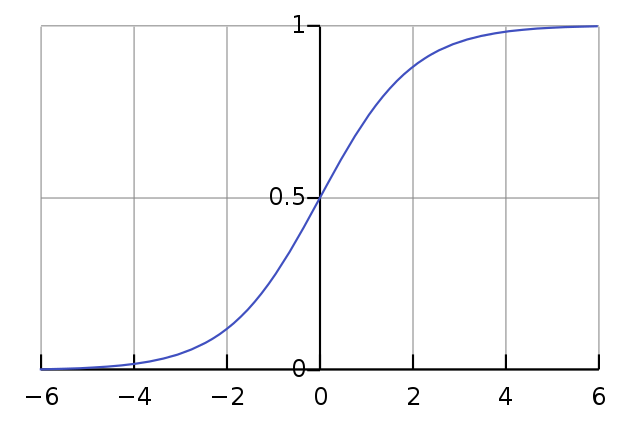
[[2](https://en.wikipedia.org/wiki/File:Logistic-curve.svg)]


However other activation functions do exist, and others are often better than the starting sigmoid function above. Desireable properties of activation functions are that they are:

* *non-linear* - As a two-layer ANN can be proven to be a universal function approximator with *non-linear* nodes.
* Range – When the range of the activation function is finite, gradient-based training methods tend to be more stable, because pattern presentations significantly affect only limited weights. When the range is infinite, training is generally more efficient because pattern presentations significantly affect most of the weights. In the latter case, smaller learning rates are typically necessary.
* Continuously differentiable – This property is desirable (RELU is not continuously differentiable and has some issues with gradient-based optimization, but it is still possible) for enabling gradient-based optimization methods. The binary step activation function is not differentiable at 0, and it differentiates to 0 for all other values, so gradient-based methods can make no progress with it.
* Monotonic – When the activation function is monotonic, the error surface associated with a single-layer model is guaranteed to be convex.
* Smooth functions with a monotonic derivative – These have been shown to generalize better in some cases.
* Approximates identity near the origin – When activation functions have this property, the neural network will learn efficiently when its weights are initialized with small random values. When the activation function does not approximate identity near the origin, special care must be used when initializing the weights. In the table below, activation functions where $h(0)=0$ and $h'(0)=1$ and $h'$ is continuous at $0$ are indicated as having this property.

#### Tanh

$$h(z)=\tanh(z)=\frac{(e^{z} - e^{-z})}{(e^{z} + e^{-z})}$$

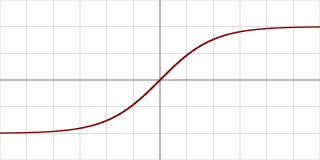
[[3](https://en.wikipedia.org/wiki/File:Activation_tanh.svg)]


#### RELU

$$h(z) = \begin{cases}
0 & \text{for } z \le 0\\
z & \text{for } z > 0
\end{cases} $$

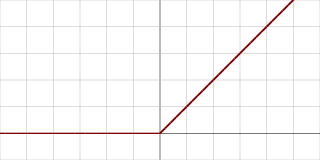
[[4](https://en.wikipedia.org/wiki/File:Activation_rectified_linear.svg)]

Can see more activation functions [here](https://www.wikiwand.com/en/Activation_function)

# Creating a artifical neural network with TensorFlow 2.0 from scratch

In [2]:
# Load the digits dataset that we have been using
from sklearn import datasets
from sklearn.model_selection import train_test_split
digits = datasets.load_digits()

(X, y) = datasets.load_digits(return_X_y=True)
X = X.astype(np.float32)
y = y.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [3]:
# Let us define a layer of neursons as
n_inputs = 8*8
n_hidden_1 = 25
n_hidden_2 = 25
n_outputs = 10


class NNLayer(object):
    def __init__(self, n_inputs, n_neurons, activation=None):
        init = tf.random.normal((n_inputs, n_neurons),
                                stddev=2 / np.sqrt(n_inputs))
        self.W = tf.Variable(init, name="kernel")
        self.b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        self.activation = activation

    def __call__(self, X):
        Z = tf.matmul(X, self.W) + self.b
        if self.activation is not None:
            return self.activation(Z)
        else:
            return Z

    def trainable_variables(self):
        return [self.W, self.b]


class Model(object):
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def trainable_variables(self):
        variables = []
        for layer in self.layers:
            variables.extend(layer.trainable_variables())
        return variables


# Instantiate loss function
loss_function = tf.nn.sparse_softmax_cross_entropy_with_logits

# Create our custom model with our layers
model = Model([
    NNLayer(n_inputs, n_hidden_1, activation=tf.nn.relu),
    NNLayer(n_hidden_1, n_hidden_2, activation=tf.nn.relu),
    NNLayer(n_hidden_2, n_outputs)
])


def loss(model, X, y_true):
    y_pred = model(X)
    return tf.reduce_mean(tf.dtypes.cast(loss_function(labels=y_true, logits=y_pred),
                                         tf.float32), name="loss")


l = loss(model, X_train, y_train)
print('Test the starting loss: ', l)

Test the starting loss:  tf.Tensor(38.289455, shape=(), dtype=float32)


In [4]:
def grad(model, X, y_true):
    with tf.GradientTape() as tape:
        loss_value = loss(model, X, y_true)
    return loss_value, tape.gradient(loss_value, model.trainable_variables())


optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

loss_value, grads = grad(model, X_train, y_train)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables()))

print("Step: {},         Loss: {}\n\n".format(optimizer.iterations.numpy(),
                                          loss(model, X_train, y_train).numpy()))

train_loss_results = []
train_accuracy_results = []

num_epochs = 2001

for epoch in range(num_epochs):


    loss_value, grads = grad(model, X_train, y_train)
    optimizer.apply_gradients(zip(grads, model.trainable_variables()))

    y_pred = model(X_train)
    correct = tf.equal(tf.math.argmax(y_pred, axis=1), y_train)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    train_loss_results.append(loss_value.numpy())
    train_accuracy_results.append(accuracy)
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    loss_value.numpy(),
                                                                    accuracy))

Step: 0, Initial Loss: 38.28945541381836
Step: 1,         Loss: 29.21148681640625


Epoch 000: Loss: 29.211, Accuracy: 11.273%
Epoch 050: Loss: 1.135, Accuracy: 68.476%
Epoch 100: Loss: 0.681, Accuracy: 79.402%
Epoch 150: Loss: 0.493, Accuracy: 85.873%
Epoch 200: Loss: 0.381, Accuracy: 88.727%
Epoch 250: Loss: 0.310, Accuracy: 90.675%
Epoch 300: Loss: 0.257, Accuracy: 92.276%
Epoch 350: Loss: 0.217, Accuracy: 93.528%
Epoch 400: Loss: 0.188, Accuracy: 94.502%
Epoch 450: Loss: 0.166, Accuracy: 95.129%
Epoch 500: Loss: 0.148, Accuracy: 95.477%
Epoch 550: Loss: 0.133, Accuracy: 96.242%
Epoch 600: Loss: 0.120, Accuracy: 96.451%
Epoch 650: Loss: 0.108, Accuracy: 97.008%
Epoch 700: Loss: 0.098, Accuracy: 97.564%
Epoch 750: Loss: 0.089, Accuracy: 97.843%
Epoch 800: Loss: 0.082, Accuracy: 98.121%
Epoch 850: Loss: 0.076, Accuracy: 98.539%
Epoch 900: Loss: 0.070, Accuracy: 98.608%
Epoch 950: Loss: 0.066, Accuracy: 98.747%
Epoch 1000: Loss: 0.061, Accuracy: 98.817%
Epoch 1050: Loss: 0.057, Accurac

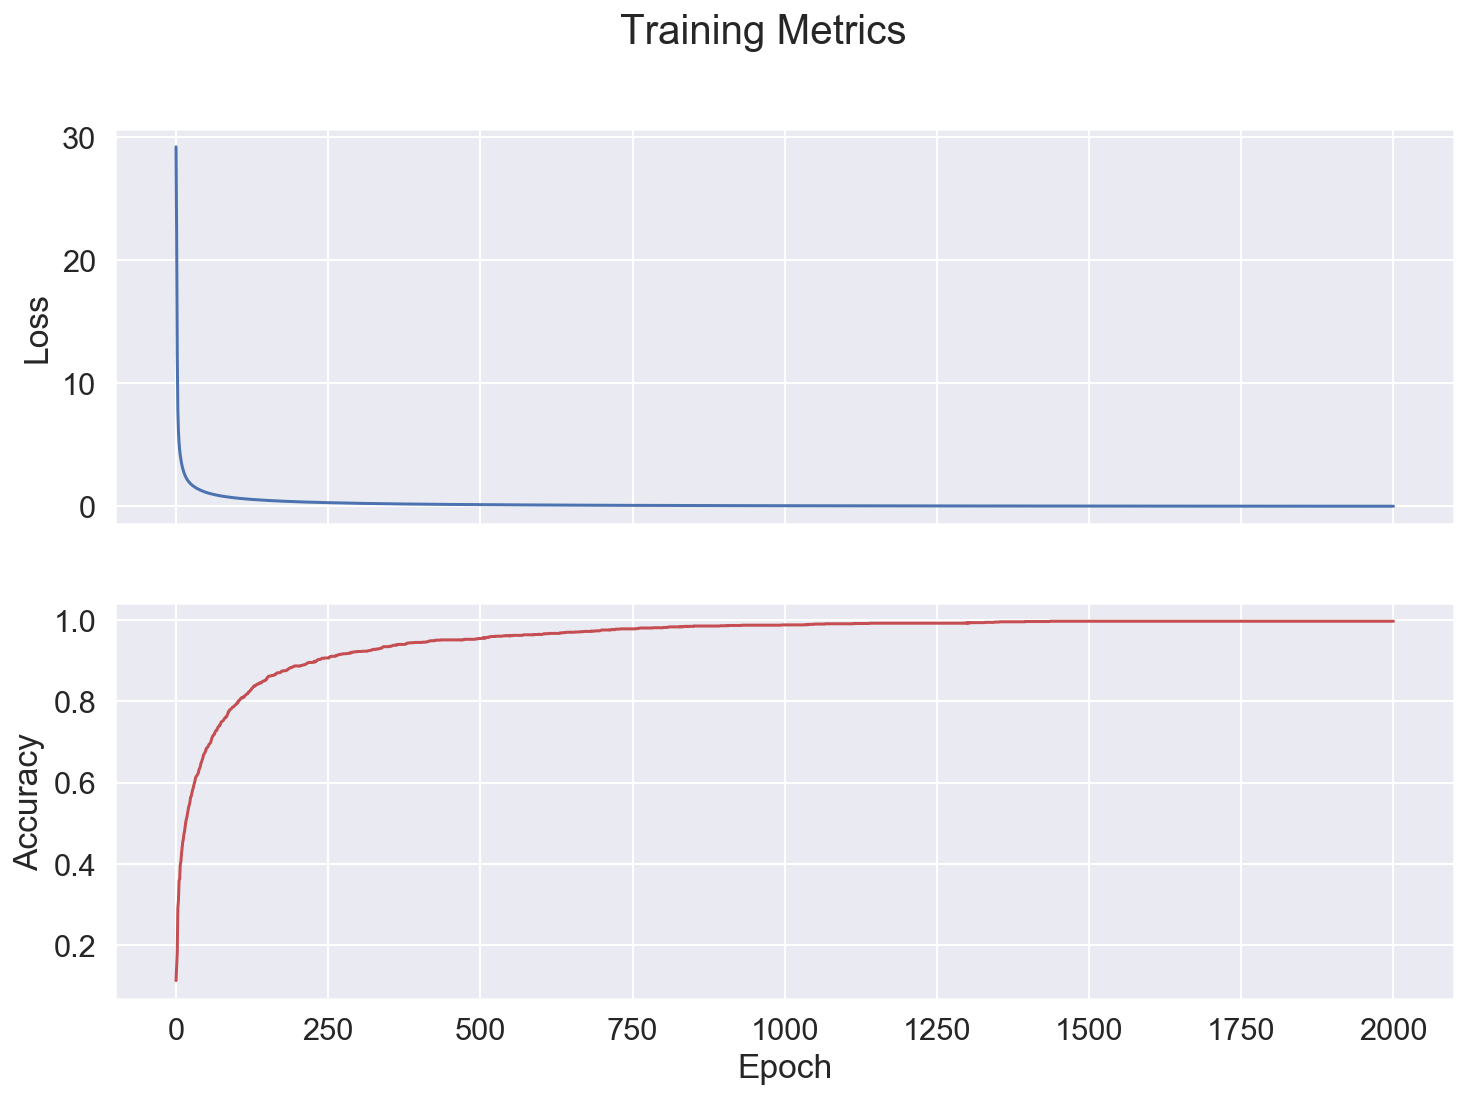

In [5]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss")
axes[0].plot(train_loss_results, 'b')

axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].plot(train_accuracy_results, 'r')
plt.show()

In [6]:
# Evaluate the testing accuracy
y_test_pred = model(X_test)
test_correct = tf.equal(tf.math.argmax(y_test_pred, axis=1), y_test)
test_accuracy = tf.reduce_mean(tf.cast(test_correct, tf.float32))
print('Test accuracy: {:.3%}'.format(test_accuracy))

Test accuracy: 93.333%


In [7]:
y_test_pred[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ -0.74840236,  -2.6726933 ,   1.3947974 ,   7.3572836 ,
       -11.5284    ,  -4.8792014 ,  17.954473  ,  -0.8367879 ,
        11.876232  ,   0.23709174], dtype=float32)>

Inspecting a test example 

Output probability distribution 
               0
6  9.976879e-01
8  2.286905e-03
3  2.492835e-05
2  6.415333e-08
9  2.015734e-08
0  7.523835e-09
7  6.887371e-09
1  1.098323e-09
5  1.209081e-10
4  1.565832e-13


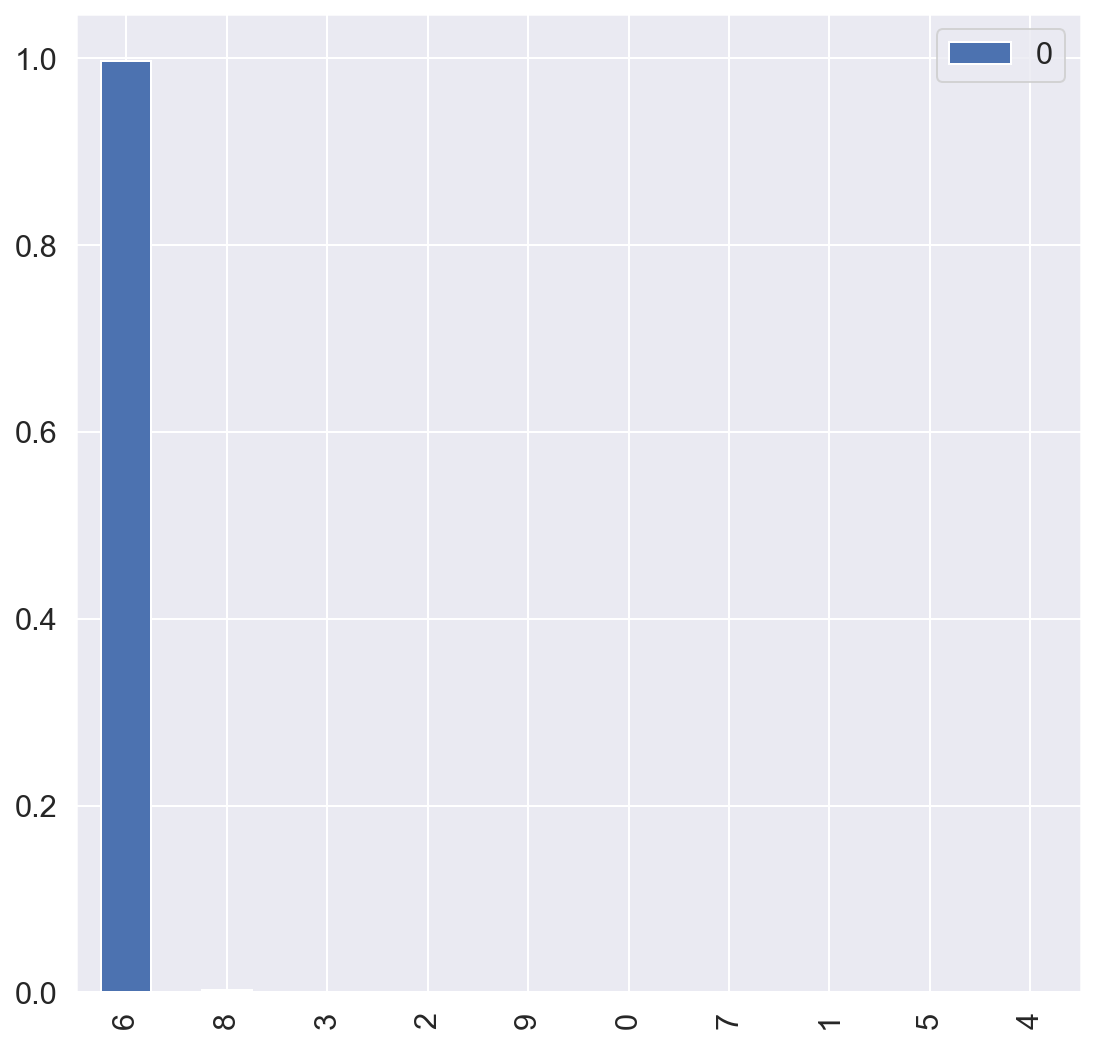

In [8]:
output_dist = tf.nn.softmax(y_test_pred[0])
df_output_dist = pd.DataFrame(output_dist).sort_values(0, ascending=False)
print('Inspecting a test example \n\nOutput probability distribution \n', df_output_dist)
df_output_dist.plot.bar(y=0)
plt.show()

# Using Keras to create the same ANN

Keras is an high-level library for working with neural networks, capable of running the Tensorflow backend, and comes integrated into TensorFlow. It was developed to enable fast experimentation. It attempts to reduce cognitive load by being user friendly with simple APIs, is modular allowing easy plugging together of neural layers, cost functions, optomizers, activation functions, regularization scheme modules and is easy to extend to add our own custom module.

Below is an abstraction diagram for the library, the library is `tf.keras`


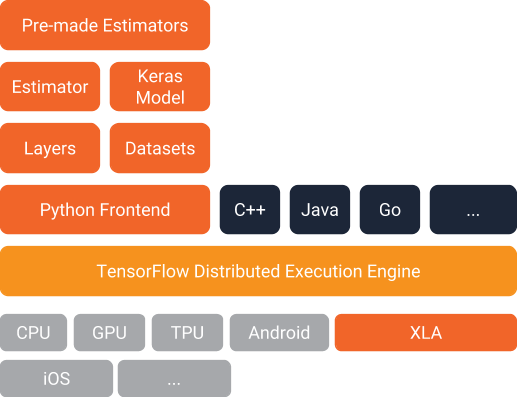
[[5](https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html)]

In [9]:
from tensorflow import keras

n_inputs = 8*8
n_hidden_1 = 25
n_hidden_2 = 25
n_outputs = 10

# Lets build the same ANN as above
model = keras.Sequential([
    keras.layers.Dense(n_hidden_1, activation='relu', input_dim=n_inputs),
    keras.layers.Dense(n_hidden_2, activation='relu'),
    keras.layers.Dense(n_outputs)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)


# Evaluate the accuracy
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

y_pred = tf.argmax(probability_model.predict(X_test), axis=1).numpy()

test_correct = tf.equal(y_pred, y_test)
test_accuracy = tf.reduce_mean(tf.cast(test_correct, tf.float32))

print('\n\nFinal Training Accuracy: {:.3%}'.format(test_accuracy))

Train on 1437 samples
Epoch 1/100
1437/1437 [==============================] - 0s 161us/sample - loss: 2.0052 - accuracy: 0.3987
Epoch 2/100
1437/1437 [==============================] - 0s 30us/sample - loss: 1.0856 - accuracy: 0.6249
Epoch 3/100
1437/1437 [==============================] - 0s 29us/sample - loss: 0.8030 - accuracy: 0.7286
Epoch 4/100
1437/1437 [==============================] - 0s 28us/sample - loss: 0.6420 - accuracy: 0.7787
Epoch 5/100
1437/1437 [==============================] - 0s 28us/sample - loss: 0.5382 - accuracy: 0.8323
Epoch 6/100
1437/1437 [==============================] - 0s 28us/sample - loss: 0.4503 - accuracy: 0.8594
Epoch 7/100
1437/1437 [==============================] - 0s 28us/sample - loss: 0.3866 - accuracy: 0.8699
Epoch 8/100
1437/1437 [==============================] - 0s 31us/sample - loss: 0.3372 - accuracy: 0.8907
Epoch 9/100
1437/1437 [==============================] - 0s 31us/sample - loss: 0.2943 - accuracy: 0.9061
Epoch 10/100
1437/1437 

In [10]:
# Evaluate the testing accuracy
y_test_pred = model(X_test)
test_correct = tf.equal(tf.math.argmax(y_test_pred, axis=1), y_test)
test_accuracy = tf.reduce_mean(tf.cast(test_correct, tf.float32))
print('Test accuracy: {:.3%}'.format(test_accuracy))

Test accuracy: 96.944%


In [11]:
# Can also use the Keras API to evaluate the accuracy and loss for us
(loss_value, test_accuracy) = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy: {:.3%}'.format(test_accuracy))

360/360 - 0s - loss: 0.1420 - accuracy: 0.9694
Test accuracy: 96.944%


## Introduction to Keras

Using Keras, we assemble layers to build a model. There are different layer types, the one we used above for a multi-layer perceptron model `tf.keras.Sequential` was the `tf.keras.layers.Dense` layer (for fully connected layers).

### Layers

There are many layer types, some of the most common types are pooling layers, convolutional layers, cropping layers, dropout, flatten, softmax and padding layers. The complete list of all layers can be seen [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

Most of the layers share common constructor arguments:
* `activation`: Defines the activation function for the neurons in that layer. Specified as the name of the built-in function or as a callable activation function. By default no activation is applied.
* `kernel_initializer` and `bias_initializer`: The initialization methods that create the layer's weights (kernel and bias). Again this parameter is a name or a callable object. The kernel defaults to the "Glorot uniform" initializer, and the bias defaults to zeros.
* `kernel_regularizer` and `bias_regularizer`: The regularization methods that apply the layer's weights (kernel and bias), such as $l1$ or $l2$ regularization. By default no regularization is applied.

In [12]:
# i.e.

# Where Units is an integer specifying how many units (neurons) this dense layer has
units = 10
tf.keras.layers.Dense(
    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
)

### Compiling the model

`tf.keras.Model.compile` takes important arguments: 
* `optimizer`: This object specifies the training procedure. Pass it optimizer instances from the `tf.keras.optimizers` module, such as `tf.keras.optimizers.SGD`. We can also sepcify the name of the built-in function as well, i.e. 'sgd'.
* `loss`: The function to minimize during optimization. Popular choices include the mean square error (*mse*), *categorical_crossentropy*, and *binary_crossentropy*. Pass it an loss intance from the `tf.keras.losses` module, or specify the built-in function as a string again.
* `metrics`: Used to monitor training. Similarly pass it an instance from the `tf.keras.metrics` module or specify the built-in function as a string.

In [13]:
# i.e.

model = tf.keras.Sequential([
    # Adds a densely-connected layer with 32 units (nuerons) to the model:
    keras.layers.Dense(32, activation='relu', input_shape=(16,)),
    keras.layers.Dense(32, activation='relu'),
    # Add an output layer with 5 output units:
    keras.layers.Dense(5)])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

We can use the `tf.keras.Model.fit` method, to fit the compiled model on the training data

In [16]:
# Dummy data
X_train = np.random.random((1000, 16))
y_train = np.random.random((1000, 5))

model.fit(X_train, y_train, epochs=10, batch_size=32)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s 282us/sample - loss: 4.9315 - accuracy: 0.1990
Epoch 2/10
1000/1000 [==============================] - 0s 37us/sample - loss: 7.3662 - accuracy: 0.2070
Epoch 3/10
1000/1000 [==============================] - 0s 33us/sample - loss: 30.9371 - accuracy: 0.2200
Epoch 4/10
1000/1000 [==============================] - 0s 35us/sample - loss: 93.1389 - accuracy: 0.2050
Epoch 5/10
1000/1000 [==============================] - 0s 34us/sample - loss: 158.8274 - accuracy: 0.2030
Epoch 6/10
1000/1000 [==============================] - 0s 36us/sample - loss: 321.6838 - accuracy: 0.1970
Epoch 7/10
1000/1000 [==============================] - 0s 35us/sample - loss: 489.6644 - accuracy: 0.1650
Epoch 8/10
1000/1000 [==============================] - 0s 33us/sample - loss: 696.8379 - accuracy: 0.1910
Epoch 9/10
1000/1000 [==============================] - 0s 31us/sample - loss: 1201.3790 - accuracy: 0.2070
Epoch 10/10
1000/10

We can see here that the `tf.keras.Model.fit` takes three useful arguments:

* `epochs`: Training is structured into epochs. Where an epoch is one iteration over the entire input data (this is done in smaller batches).
* `batch_size`: When passed NumPy data, the model slices the data into smaller batches and iterates over these batches during training. This integer specifies the size of each batch.
* `validation_data`: Most useful when prototyping a model, you want to easily monitor its performance on some validation data. Passing this argument—a tuple of *X_val* and *y_val* (targets) allows the model to display the loss and metrics in inference mode for the passed data, at the end of each epoch.

In [18]:
X_val = np.random.random((100, 16))
y_val = np.random.random((100, 5))

model.fit(X_train, y_train, epochs=10, batch_size=32,
          validation_data=(X_val, y_val))

Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 0s 49us/sample - loss: 1427.1295 - accuracy: 0.2010 - val_loss: 1745.2583 - val_accuracy: 0.1800
Epoch 2/10
1000/1000 [==============================] - 0s 48us/sample - loss: 2119.8962 - accuracy: 0.1970 - val_loss: 3182.2306 - val_accuracy: 0.2100
Epoch 3/10
1000/1000 [==============================] - 0s 49us/sample - loss: 1981.0364 - accuracy: 0.1890 - val_loss: 2351.0019 - val_accuracy: 0.1700
Epoch 4/10
1000/1000 [==============================] - 0s 49us/sample - loss: 2059.0557 - accuracy: 0.1780 - val_loss: 2881.1984 - val_accuracy: 0.1800
Epoch 5/10
1000/1000 [==============================] - 0s 49us/sample - loss: 2395.9244 - accuracy: 0.1980 - val_loss: 4144.3232 - val_accuracy: 0.1800
Epoch 6/10
1000/1000 [==============================] - 0s 51us/sample - loss: 3290.6064 - accuracy: 0.1840 - val_loss: 4288.0526 - val_accuracy: 0.1800
Epoch 7/10
1000/1000 [=============

This also integrates nicely with TensorFlow's dataset API, to process large datasets or multi-device training. I.e. we can pass a `tf.data.Dataset` instance to the method as well. We can also pass this datatype for the `validation_data` too. Since the Dataset yields batches of data, this we don't need to set a `batch_size`. For example

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.batch(32)

model.fit(dataset, epochs=10)

Train for 32 steps
Epoch 1/10
32/32 [==============================] - 0s 6ms/step - loss: 4822.6660 - accuracy: 0.1940
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 5327.0932 - accuracy: 0.2040
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 6576.9873 - accuracy: 0.2030
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 5647.2886 - accuracy: 0.1940
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 8862.0281 - accuracy: 0.1850
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 9894.9141 - accuracy: 0.2110
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 9646.7574 - accuracy: 0.1850
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 9110.2422 - accuracy: 0.2070
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 9506.7881 - accuracy: 0.2020
Epoch 10/10
32/32 [==============================] - 0s 1ms/step - loss:

### Evaluating and predicting the model

The `tf.keras.Model.evaluate` and `tf.keras.Model.predict` methods return the model loss and any specific `metrics` for the model. They work with either numpy arrays or the tf's dataset object

In [20]:
model.evaluate(X_train, y_train, batch_size=32)
# Or
model.evaluate(dataset)

32/32 [==============================] - 0s 3ms/step - loss: 7179.3707 - accuracy: 0.1880


[7179.370697021484, 0.188]

### Saving and loading

##### Weights

We can save and load the weights using `tf.keras.Model.save_weights`, saving in the *TensorFlow checkpoint* file format. However you can change to the Keras HDF5 format by passing `save_format='h5'`

In [21]:
# Save weights to a TensorFlow Checkpoint file
model.save_weights('./weights/my_model')

# Restore the model's state,
# this requires a model with the same architecture.
model.load_weights('./weights/my_model')

##### Model config

We can serialize the model architecture as in JSON (or YAML), which we can store in a file and read out again.

In [22]:
import json
from pprint import pprint

# Serialize a model to JSON format
json_string = model.to_json()
pprint(json.loads(json_string))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'layers': [{'class_name': 'Dense',
                        'config': {'activation': 'relu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 16],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'dtype': 'float32',
                                   'kernel_constraint': None,
                                   'kernel_initializer': {'class_name': 'GlorotUniform',
                                                          'config': {'seed': None}},
                                   'kernel_regularizer': None,
                                   'name': 'dense_4',
                             

In [23]:
# To recreate the model we can use
fresh_model = tf.keras.models.model_from_json(json_string)

##### Saving the entire model in one file

Saving the weights, model configuation including the optomizers configuration. This allows to checkpoint a model and resume training later, from the exact same state without having to have access to the original code.

In [24]:
# Save entire model to a HDF5 file
model.save('my_model')

# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model/assets


[[6](https://www.tensorflow.org/guide/keras/overview)]